# DPAA Likelihood of Identification Model
<p>John Bonfardeci <br/>
2020-04-29</p>

<p>This model attempts to estimate the probability/likelihood of identifying MIA/KIAs based on historical DPAA data for identifications.</p>

In [1]:
import pandas as pd
import dask
from dask import dataframe as ddf
import re
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error \
    , accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sb
from statsmodels.nonparametric.smoothers_lowess import lowess
import pickle
import os
import s3fs
import boto3

In [23]:
DIR = 'data' # 's3://sagemaker-studio-cu1d30g82zc'
raw_data_path = DIR+'/randomized_rus.csv'
score_data_path = DIR+'/data/unidentified.csv'
ID_COL = 'icf_r_object_id'
TARGET = 'Identified'

schema = {
    'icf_r_object_id': 'object',
    'icf_r_category_id': 'int32',
    'Identified': 'uint8',
    'bio_ancestry': 'category',
    'bio_sex': 'category',
    'bio_height_in_max': 'float16',
    'bio_height_in_min': 'float16',
    'bio_biological_profile_type': 'category',
    'bio_burn': 'uint8',
    'bio_mangled': 'uint8',
    'icf_loe_chest_radio': 'uint8',
    'icf_loe_auto_dna_ref': 'uint8',
    'icf_loe_y_dna_ref': 'uint8',
    'icf_loe_mito_dna_ref': 'uint8',
    'icf_loe_dental_profile': 'uint8',
    'icf_home_rec_city': 'category',
    'icf_home_rec_state': 'category',
    'icf_pow': 'uint8',
    'icf_loe_bio_profile': 'uint8',
    'icf_service_branch': 'category',
    'icf_conflict': 'category',
    'icf_unit': 'category',
    'icf_conflict_status_code': 'category',
    'icf_mccain_releasability': 'category',
    'icf_loss_area_historical': 'category',
    'icf_loss_area_current': 'category',
    'icf_religion': 'category',
    'icf_country': 'category',
    'has_historian_comments': 'uint8',
    'loc_accuracy': 'category',
    'loc_coord_origin': 'category',
    'loc_body_of_water': 'category',
    'loc_country': 'category'
}

# Exclude these categorical columns until we can find a way to group them into broader categories. They have too many levels to model.
exclude = ['icf_r_object_id', 'icf_r_category_id', 'Identified', 'icf_home_rec_city', 'icf_unit', 
           'icf_loss_area_historical', 'icf_loss_area_current', 'icf_religion', 'loc_country']

num_features = [p for p in schema if schema[p] != 'category' and p not in exclude]

cat_features = [p for p in schema if schema[p] == 'category' and p not in exclude]

keep = [TARGET]
keep.extend(num_features)
keep.extend(cat_features)

data = pd.read_csv(raw_data_path, dtype=schema)
data = data[keep]
#data.dropna(inplace=True) # 4 rows with 'loc_country' = 'N/A'
data.head()

Identified  bio_height_in_max  bio_height_in_min  bio_burn  bio_mangled  \
0           1               72.0               72.0         0            0   
1           1                0.0                0.0         0            0   
2           1                0.0                0.0         0            0   
3           1                0.0                0.0         0            0   
4           1                0.0                0.0         0            0   

   icf_loe_chest_radio  icf_loe_auto_dna_ref  icf_loe_y_dna_ref  \
0                    0                     0                  0   
1                    0                     0                  0   
2                    0                     0                  0   
3                    0                     0                  0   
4                    0                     0                  0   

   icf_loe_mito_dna_ref  icf_loe_dental_profile  ...  \
0                     0                       0  ...   
1                     0                       0  ...   
2                     0                       0  ...   
3                     0                       0  ...   
4                     0                       0  ...   

   bio_biological_profile_type  icf_home_rec_state  \
0               Antemortem ICF             UNKNOWN   
1               Antemortem ICF             UNKNOWN   
2               Antemortem ICF             UNKNOWN   
3               Antemortem ICF               TEXAS   
4               Antemortem ICF             FLORIDA   

              icf_service_branch  icf_conflict  \
0  UNITED STATES ARMY AIR FORCES  WORLD WAR II   
1     UNITED STATES MARINE CORPS  WORLD WAR II   
2  UNITED STATES MERCHANT MARINE  WORLD WAR II   
3     UNITED STATES MARINE CORPS   VIETNAM WAR   
4             UNITED STATES ARMY  WORLD WAR II   

                 icf_conflict_status_code icf_mccain_releasability  \
0  ADMINISTRATIVE DECISION (GROUP BURIAL)                     -NA-   
1                        ACCORDING TO NOK                     -NA-   
2                                  CLOSED                     -NA-   
3                                 UNKNOWN                     -NA-   
4                        ACCORDING TO NOK                     -NA-   

        icf_country loc_accuracy loc_coord_origin loc_body_of_water  
0  PAPUA NEW GUINEA           10          UNKNOWN  PAPUA NEW GUINEA  
1           UNKNOWN      UNKNOWN          UNKNOWN              -NA-  
2           UNKNOWN      UNKNOWN          UNKNOWN              -NA-  
3           UNKNOWN      UNKNOWN          UNKNOWN              -NA-  
4           UNKNOWN      UNKNOWN          UNKNOWN              -NA-  

[5 rows x 25 columns]

In [24]:
data.columns

Index(['Identified', 'bio_height_in_max', 'bio_height_in_min', 'bio_burn',
       'bio_mangled', 'icf_loe_chest_radio', 'icf_loe_auto_dna_ref',
       'icf_loe_y_dna_ref', 'icf_loe_mito_dna_ref', 'icf_loe_dental_profile',
       'icf_pow', 'icf_loe_bio_profile', 'has_historian_comments',
       'bio_ancestry', 'bio_sex', 'bio_biological_profile_type',
       'icf_home_rec_state', 'icf_service_branch', 'icf_conflict',
       'icf_conflict_status_code', 'icf_mccain_releasability', 'icf_country',
       'loc_accuracy', 'loc_coord_origin', 'loc_body_of_water'],
      dtype='object')

## Helper Functions

In [4]:
def mmp(x, prob, actual, title='Actual + Prob'):
    """
    Marginal Model Plots for Binary Model Fit Validation
    Based on methodology established by Weisberg, 2005.
    """
    yhat = lowess(endog=prob, exog=x, frac=.2, it=0)
    x1 = yhat[:,0]
    y1 = yhat[:,1]

    Y = lowess(endog=actual, exog=x, frac=.2, it=0)
    x2 = Y[:,0]
    y2 = Y[:,1]
  
    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x1, y1, color='blue', alpha=0.7)
    ax2.plot(x2, y2, color='red', alpha=0.7)
    ax1.set_title(title)
    ax1.set_ylabel('Actual + Prob')
    ax1.set_xlabel('X')
    plt.show()

def get_balanced_accuracy(tpr, fpr):
    """
    Return average of Sensitivity and Specificity.
    """
    return (tpr + (1-fpr)) / 2

def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    @param 2D array <list<list>>
    @returns <list<float>>
    """
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])
    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))
    return [tpr, fpr]

def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01

    @param actual <list<float>>
    @param prob <list<tuple<float, float>>>
    @returns <list<float>>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    cm = [[0,0],[0,0]]
    while cutoff < 1.0:
        pred = list(map(lambda p: 1 if p >= cutoff else 0, prob))
        _cm = confusion_matrix(actual, pred)
        _tpr, _fpr = get_tpr_fpr(_cm)
        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)
            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
                cm = _cm

        cutoff += 0.01

    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    return [best_tpr, best_fpr, best_cutoff, tn, fp, fn, tp]
    
# create confusion matrix
def get_predict_frame(actual, prob, model_name='Logit'):
    """
    Compute predicted based on estimated probabilities and best threshold. 
    Output predictions and confusion matrix.
    """
    # calculate TPR, FPR, best probability threshold
    tpr, fpr, cutoff, tn, fp, fn, tp = get_best_cutoff(actual, prob)
    accuracy = get_balanced_accuracy(tpr, fpr)
    auc = roc_auc_score(actual, prob)
    
    #print("Optimal prob. threshold is %0.3f: " % cutoff)
    yhat = list(map(lambda p: 1 if p >= cutoff else 0, prob))
    stats = pd.DataFrame(columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Cutoff', 'Accuracy', 'AUC'],
                data=[[model_name, tp, fp, tn, fn, tpr, (1-fpr), cutoff, accuracy, auc]])

    print("Sensitivity: {0:.3f}%, Specificity: {1:.3f}%, Threshold: {2:.3f}".format(tpr*100, (1-fpr)*100, cutoff))
    return yhat, stats

def plot_roc(actual, prob):
    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actual, prob)

    # plot ROC curve
    fig = plt.figure(figsize=(10, 10))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.show()
    
def clean_column_names(column_names):
    return list(map(lambda col: re.sub(r'(^_+|_+$)', '', re.sub(r'_+', '_', re.sub(r'[^a-zA-Z0-9_]', '_', col) ) ), column_names))

## Transform Data

In [14]:
data = pd.get_dummies(data)
#data.columns = clean_column_names(data.columns)
# Exclude features with values = 'UNKNOWN' or '-NA-'. 
# Exclude 'NOK' feature (Next of Kin) which means the NOK accepted an ID, which means the soldier was identified.
selected_columns = [c for c in data.columns if not re.findall(r'(UNKNOWN|NOK|NON RECOVERABLE|-NA-)', c)]
data = data[selected_columns]

In [15]:
features = data.drop([TARGET], 1)
target = data[TARGET]
column_names = features.columns

x_train, x_val, y_train, y_val = train_test_split(features.values, target.values, test_size=0.3, random_state=123)

In [16]:
df_train = pd.DataFrame(columns=column_names, data=x_train)
df_train[TARGET] = y_train
df_val = pd.DataFrame(columns=column_names, data=x_val)
df_val[TARGET] = y_val

## Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
force_new_model = True

"""
if(os.path.exists(s3bucket+'/forest_model.p') and not force_new_model):
    forest_model = pickle.load(open(s3bucket+'/forest_model.p', 'rb'))
else:
    rfc = RandomForestClassifier(max_depth=10, random_state=123, n_jobs=8)
    forest_model = rfc.fit(x_train, y_train)
    pickle.dump(forest_model, open(s3bucket+'/forest_model.p', 'wb'))
"""

rfc = RandomForestClassifier(max_depth=10, random_state=123, n_jobs=8)
forest_model = rfc.fit(x_train, y_train)

## Assess Validity

Sensitivity: 86.586%, Specificity: 89.305%, Threshold: 0.970


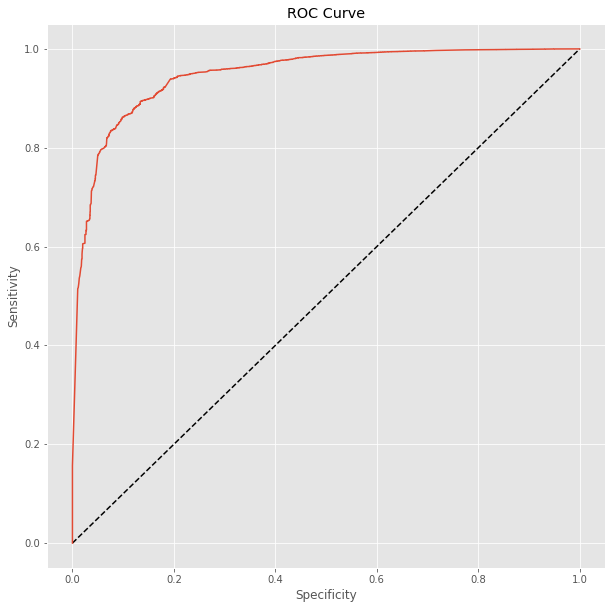

               Model      TP   FP    TN     FN  Sensitivity  Specificity  \
0  Scikit Forest Val  101995  317  2647  15801     0.865861      0.89305   

   Cutoff  Accuracy       AUC  
0    0.97  0.879456  0.948423  


In [18]:
forest_predictions = forest_model.predict(x_val)
forest_y_scores = forest_model.predict_proba(x_val)
forest_prob = forest_y_scores[:,1]
forest_yhat, forest_stats = get_predict_frame(y_val, forest_prob, 'Scikit Forest Val')
plot_roc(y_val, forest_prob)
print(forest_stats.head())

### Marginal Model Plot(s)
Plot numerical features estimated probabilities against actual for goodness-of-fit.

/home/jbonfardeci/miniconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


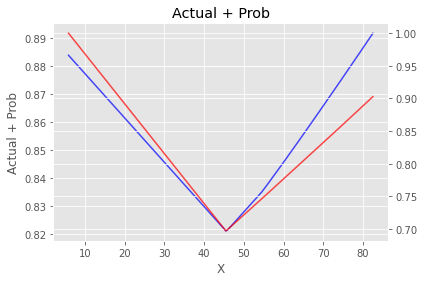

In [19]:
mmp(df_val.bio_height_in_max, forest_prob, df_val.Identified)

### Export Feature Importance

In [20]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(column_names),
                   'importance': forest_model.feature_importances_}).\
                    sort_values('importance', ascending=False)

fi.to_csv(DIR+'/random-forest-feature-importance.csv')

In [21]:
fi.head(100)

feature  importance
157  icf_service_branch_UNITED STATES NAVY    0.066146
340                     loc_coord_origin_Q    0.063693
0                        bio_height_in_max    0.059447
7                     icf_loe_mito_dna_ref    0.051063
1                        bio_height_in_min    0.043510
..                                     ...         ...
10                     icf_loe_bio_profile    0.000875
53              icf_home_rec_state_INDIANA    0.000865
75       icf_home_rec_state_NORTH CAROLINA    0.000831
428              loc_body_of_water_VIETNAM    0.000814
372               loc_body_of_water_FRANCE    0.000812

[100 rows x 2 columns]

### Output Decision Tree

In [12]:
# Output decision tree image
"""
Not sure how to output this to S3 bucket yet.
2020-04-29
"""

# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
    
import sklearn.tree as tree
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
# Extract single tree
estimator = rfc.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = column_names,
                class_names = TARGET,
                rounded = True, 
                proportion = False, 
                precision = 2,
                filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=1200'])

# Display in jupyter notebook
Image(filename = 'tree.png')